In [ ]:
!pip install patchify albumentations[imgaug] scikit-image
# if you will write COCO later:
!pip install pycocotools
!pip install patchify
!pip install albumentations
!pip install csbdeep

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.6/71.6 kB 2.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import os
from patchify import patchify  #Only to handle large images
import random
from scipy import ndimage
from csbdeep.data import create_patches

## Connect the drive and load RAW data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

#165 large images as tiff image stack
large_images = tifffile.imread("/content/drive/MyDrive/Electron_Microscope_Practice_Projects/Mitochondria_segmentation/training.tif")
large_masks = tifffile.imread("/content/drive/MyDrive/Electron_Microscope_Practice_Projects/Mitochondria_segmentation/training_groundtruth.tif")


## working on a small sample for now

In [ ]:
# lets take a small sample:
large_images = large_images[:10]
large_masks = large_masks[:10]

In [ ]:
# image dyte
print('dtype' , large_images.dtype , 'shape' , large_images.shape, 'min' , large_images.min(), 'max',  large_images.max())

dtype uint8 shape (10, 768, 1024) min 32 max 227


## Now lets create train and validation images and seperate them to prevent data lekage

In [ ]:
from sklearn.model_selection import train_test_split

image_ids = list(range(len(large_images)))  # or use file name list
train_ids, val_ids = train_test_split(image_ids, test_size=0.2, random_state=42, shuffle=True)

print("train images:", len(train_ids), "val images:", len(val_ids))
print('train ids' , train_ids)
print('val ids' , val_ids)

train images: 8 val images: 2
train ids [5, 0, 7, 2, 9, 4, 3, 6]
val ids [8, 1]


## extract the ids and visualize the train and test sample raw images

In [ ]:
# Extract training and validation images/masks based on IDs
train_images = large_images[train_ids]
train_masks  = large_masks[train_ids]

val_images = large_images[val_ids]
val_masks  = large_masks[val_ids]

# Print summaries
print(f"Train images: {train_images.shape}, dtype={train_images.dtype}")
print(f"Train masks:  {train_masks.shape}, dtype={train_masks.dtype}")
print(f"Val images:   {val_images.shape}, dtype={val_images.dtype}")
print(f"Val masks:    {val_masks.shape}, dtype={val_masks.dtype}")

# Quick sanity check — ensure shapes match
assert train_images.shape == train_masks.shape, "Train image/mask mismatch!"
assert val_images.shape == val_masks.shape, "Val image/mask mismatch!"


Train images: (8, 768, 1024), dtype=uint8
Train masks:  (8, 768, 1024), dtype=uint8
Val images:   (2, 768, 1024), dtype=uint8
Val masks:    (2, 768, 1024), dtype=uint8


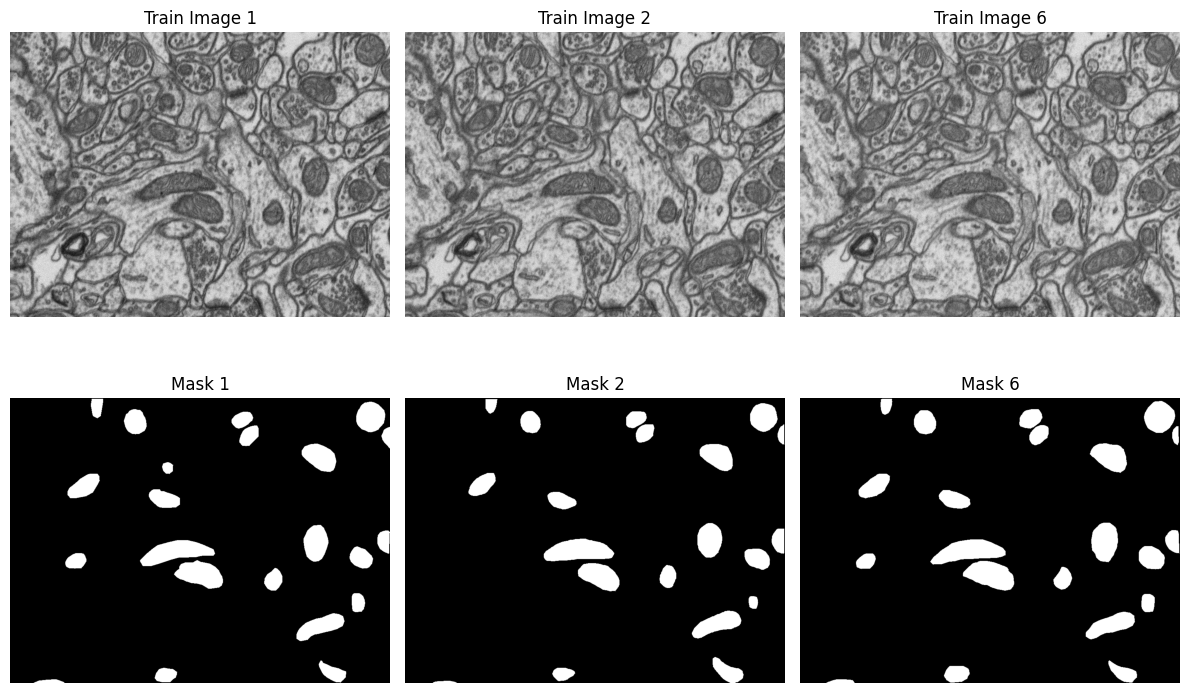

In [ ]:

# Optional: visualize a random sample
# Pick 3 unique random indices from the training set
n_show = 3
sample_ids = random.sample(range(len(train_images)), n_show)

fig, axes = plt.subplots(2, n_show, figsize=(4*n_show, 8))

for i, idx in enumerate(sample_ids):
    # Top row: image
    axes[0, i].imshow(train_images[idx], cmap='gray')
    axes[0, i].set_title(f"Train Image {idx}")
    axes[0, i].axis('off')

    # Bottom row: mask
    axes[1, i].imshow(train_masks[idx], cmap='gray')
    axes[1, i].set_title(f"Mask {idx}")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

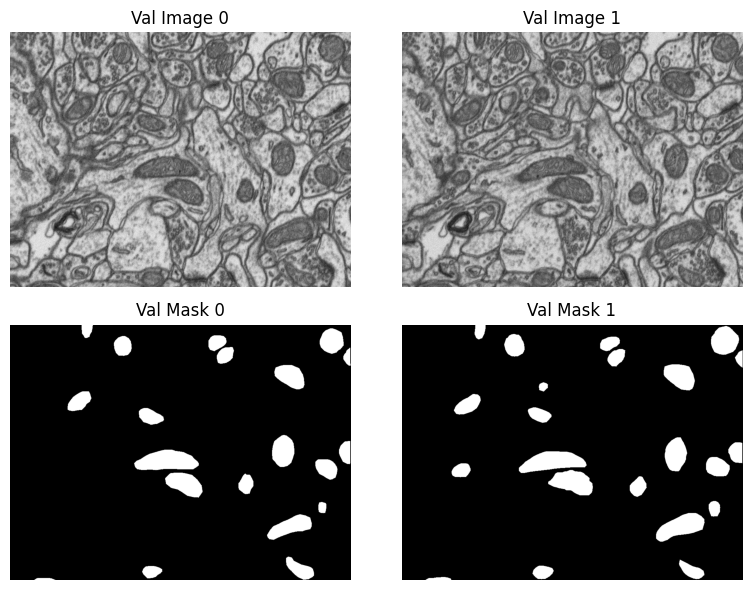

In [ ]:
sample_ids = random.sample(range(len(val_images)), min(3, len(val_images)))
fig, axes = plt.subplots(2, len(sample_ids), figsize=(4*len(sample_ids), 6))

for i, idx in enumerate(sample_ids):
    axes[0, i].imshow(val_images[idx], cmap='gray')
    axes[0, i].set_title(f"Val Image {idx}")
    axes[0, i].axis('off')

    axes[1, i].imshow(val_masks[idx], cmap='gray')
    axes[1, i].set_title(f"Val Mask {idx}")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()


## Create Patch and Filter Data

In [ ]:
import numpy as np
import cv2

def _get_starts(L, patch_size, step):
    """
    Compute valid starting indices along one dimension (0..L-1)
    so that all patches are fully inside the image, and the last
    patch touches the border. This may create extra overlap at the end.
    """
    # If image is smaller than a patch, just start at 0
    if L <= patch_size:
        return [0]

    # Regular starts with fixed step, staying inside bounds
    starts = list(range(0, L - patch_size + 1, step))

    # Ensure we also have a patch that ends exactly at L
    last_start = L - patch_size
    if last_start not in starts:
        starts.append(last_start)

    return sorted(starts)


def create_patches(image, mask, patch_size=256, overlap=32):
    """
    Divide image & mask into overlapping patches WITHOUT padding.
    Returns:
      image_patches: list of (patch_size, patch_size) arrays
      mask_patches:  list of (patch_size, patch_size) arrays
    """
    step = patch_size - overlap

    # Assume 2D grayscale; if image is 3D (H,W,C), use image.shape[:2]
    H, W = image.shape

    y_starts = _get_starts(H, patch_size, step)
    x_starts = _get_starts(W, patch_size, step)

    img_list, mask_list = [], []

    for y in y_starts:
        for x in x_starts:
            img_patch = image[y:y+patch_size, x:x+patch_size]
            mask_patch = mask[y:y+patch_size, x:x+patch_size]

            img_list.append(img_patch)
            mask_list.append(mask_patch)

    return img_list, mask_list


In [ ]:
def filter_patches(image_patches, mask_patches, min_coverage=0.005):
    """
    Filters patches based on mask coverage ratio.
    Keeps only patches where the mask has at least 'min_coverage' fraction of foreground pixels.

    Args:
        image_patches (list of np.array): Image patches
        mask_patches (list of np.array): Corresponding mask patches
        min_coverage (float): Minimum fraction of nonzero pixels required to keep patch

    Returns:
        kept_images (list)
        kept_masks (list)
    """
    kept_imgs, kept_msks = [], []
    for img, msk in zip(image_patches, mask_patches):
        ratio = np.count_nonzero(msk) / msk.size
        if ratio >= min_coverage:
            kept_imgs.append(img)
            kept_msks.append(msk)
    return kept_imgs, kept_msks


# create train image patches and filter them

In [ ]:
train_img_patches = []
train_mask_patches = []

for img, msk in zip(train_images, train_masks):
    img_patches, mask_patches = create_patches(img, msk, patch_size=256, overlap=64)
    train_img_patches.extend(img_patches)
    train_mask_patches.extend(mask_patches)

print(f"Total patches before filtering: {len(train_img_patches)}")

# ✅ Filter all patches in one go
train_filtered_imgs, train_filtered_msks = filter_patches(
    train_img_patches,
    train_mask_patches,
    min_coverage=0.009
)

print(f"After filtering: {len(train_filtered_imgs)} kept")


Total patches before filtering: 160
After filtering: 152 kept


## lets create now promt with the dataset as well.

In [ ]:
from scipy import ndimage
import numpy as np

def make_prompt_augmented_dataset(images, masks, single_prompt=True, include_global_box=True, min_size=30):
    """
    Create a prompt-augmented dataset for SAM fine-tuning.

    Args:
        images (np.ndarray): shape (N, H, W)
        masks  (np.ndarray): shape (N, H, W)
        single_prompt (bool):
            - True  -> one sample per object (A,B,C + optional global box)
            - False -> one sample with all boxes combined
        include_global_box (bool): add one large box covering all objects
        min_size (int): minimum number of pixels for a valid object

    Returns:
        aug_images (np.ndarray)
        aug_masks  (np.ndarray)
        aug_boxes  (list): each element is either [x_min,y_min,x_max,y_max] or [[...],[...],...]
    """
    aug_images, aug_masks, aug_boxes = [], [], []

    for img, mask in zip(images, masks):
        labeled_mask, n = ndimage.label(mask > 0)
        if n == 0:
            continue  # skip empty masks

        # collect all bounding boxes for objects above min_size
        object_boxes = []
        for i in range(1, n + 1):
            coords = np.column_stack(np.where(labeled_mask == i))
            if len(coords) < min_size:
                continue
            y_min, x_min = coords.min(axis=0)
            y_max, x_max = coords.max(axis=0)
            object_boxes.append([x_min, y_min, x_max, y_max])

        if not object_boxes:
            continue

        if single_prompt:
            # one entry per object box
            for box in object_boxes:
                aug_images.append(img)
                aug_masks.append(mask)
                aug_boxes.append(box)
            # optional global box
            if include_global_box and len(object_boxes) > 1:
                all_x = [b[0] for b in object_boxes] + [b[2] for b in object_boxes]
                all_y = [b[1] for b in object_boxes] + [b[3] for b in object_boxes]
                global_box = [min(all_x), min(all_y), max(all_x), max(all_y)]
                aug_images.append(img)
                aug_masks.append(mask)
                aug_boxes.append(global_box)
        else:
            # one entry with all boxes together
            aug_images.append(img)
            aug_masks.append(mask)
            aug_boxes.append(object_boxes)

    print(f"Generated {len(aug_images)} augmented samples from {len(images)} images "
          f"({'single' if single_prompt else 'multi'}-prompt mode).")
    return np.array(aug_images), np.array(aug_masks), aug_boxes

## Histogram to check mask and background ration

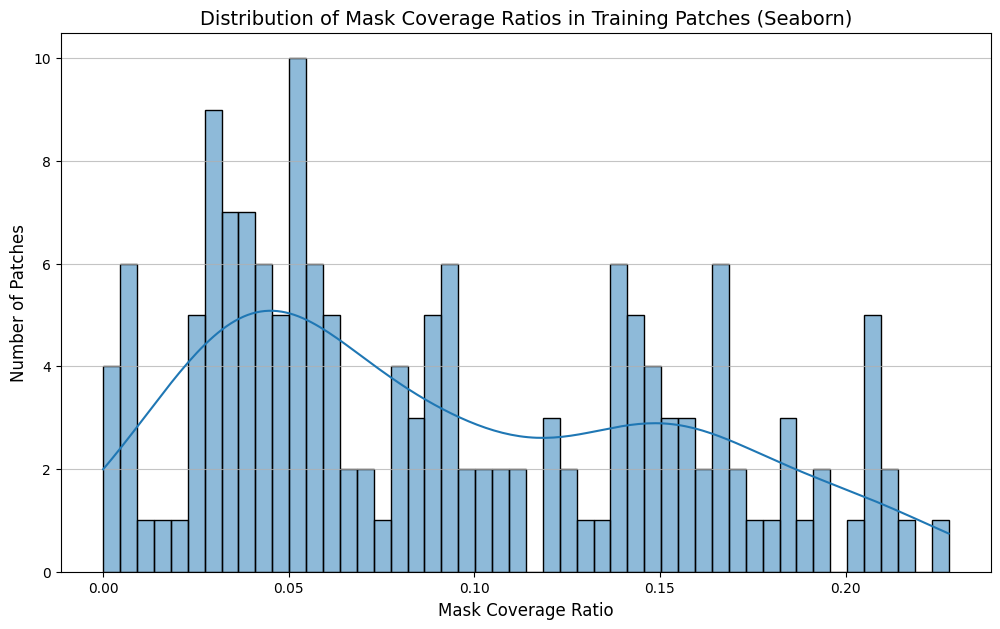

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # Import seaborn

# 1. Initialize an empty list to store the coverage ratios
coverage_ratios = []

# 2. Iterate through the train_mask_patches list
for mask_patch in train_mask_patches:
    # 3. For each mask patch, calculate its coverage ratio
    ratio = np.count_nonzero(mask_patch) / mask_patch.size
    # 4. Append each calculated coverage ratio to the list
    coverage_ratios.append(ratio)

# 5. Use seaborn.histplot() to create a histogram for better visualization
plt.figure(figsize=(12, 7)) # Slightly larger figure for better detail
sns.histplot(coverage_ratios, bins=50, kde=True, stat='count', edgecolor='black') # kde for density estimate, stat='count' for absolute counts

# 6. Add appropriate labels and a title
plt.xlabel('Mask Coverage Ratio', fontsize=12)
plt.ylabel('Number of Patches', fontsize=12)
plt.title('Distribution of Mask Coverage Ratios in Training Patches (Seaborn)', fontsize=14)

# 7. Display the histogram
plt.grid(axis='y', alpha=0.75)
plt.show()

# create validation image patches and filter them

In [ ]:
print(val_images.shape, val_masks.shape)

# Collect patches from ALL validation images
val_img_patches = []
val_mask_patches = []

for img, msk in zip(val_images, val_masks):
    img_patches, mask_patches = create_patches(
        img,
        msk,
        patch_size=256,
        overlap=32
    )
    val_img_patches.extend(img_patches)
    val_mask_patches.extend(mask_patches)

print(f"Total patches before filtering: {len(val_img_patches)}")

# Filter patches based on mask coverage
val_filtered_imgs, val_filtered_msks = filter_patches(
    val_img_patches,
    val_mask_patches,
    min_coverage=0.009
)

print(f"After filtering: {len(val_filtered_imgs)} kept")


(2, 768, 1024) (2, 768, 1024)
Total patches before filtering: 40
After filtering: 33 kept


## visualize the train dataset

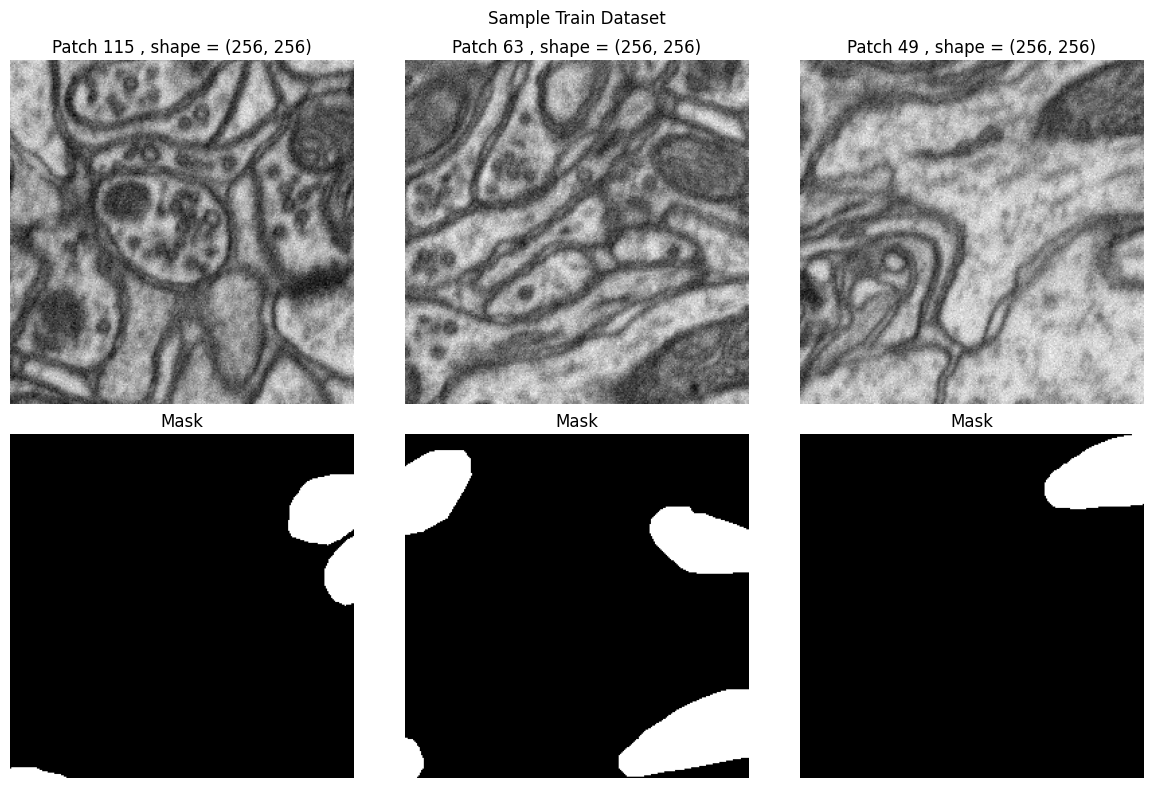

In [ ]:
# Visualize a few kept patches
n_show = 3
idxs = random.sample(range(len(train_filtered_imgs)), n_show)

fig, axes = plt.subplots(2, n_show, figsize=(4*n_show, 8))
for i, idx in enumerate(idxs):
    axes[0, i].imshow(train_filtered_imgs[idx], cmap='gray')
    # Corrected line: access .shape or .size from the image patch, not the loop counter 'i'
    axes[0, i].set_title(f"Patch {idx} , shape = {train_filtered_imgs[idx].shape}") # Using .shape for dimensions
    axes[1, i].imshow(train_filtered_msks[idx], cmap='gray')
    axes[1, i].set_title("Mask")
    for a in (axes[0,i], axes[1,i]):
        a.axis('off')
fig.suptitle('Sample Train Dataset') # Changed plt.title to fig.suptitle
plt.tight_layout()

plt.show()

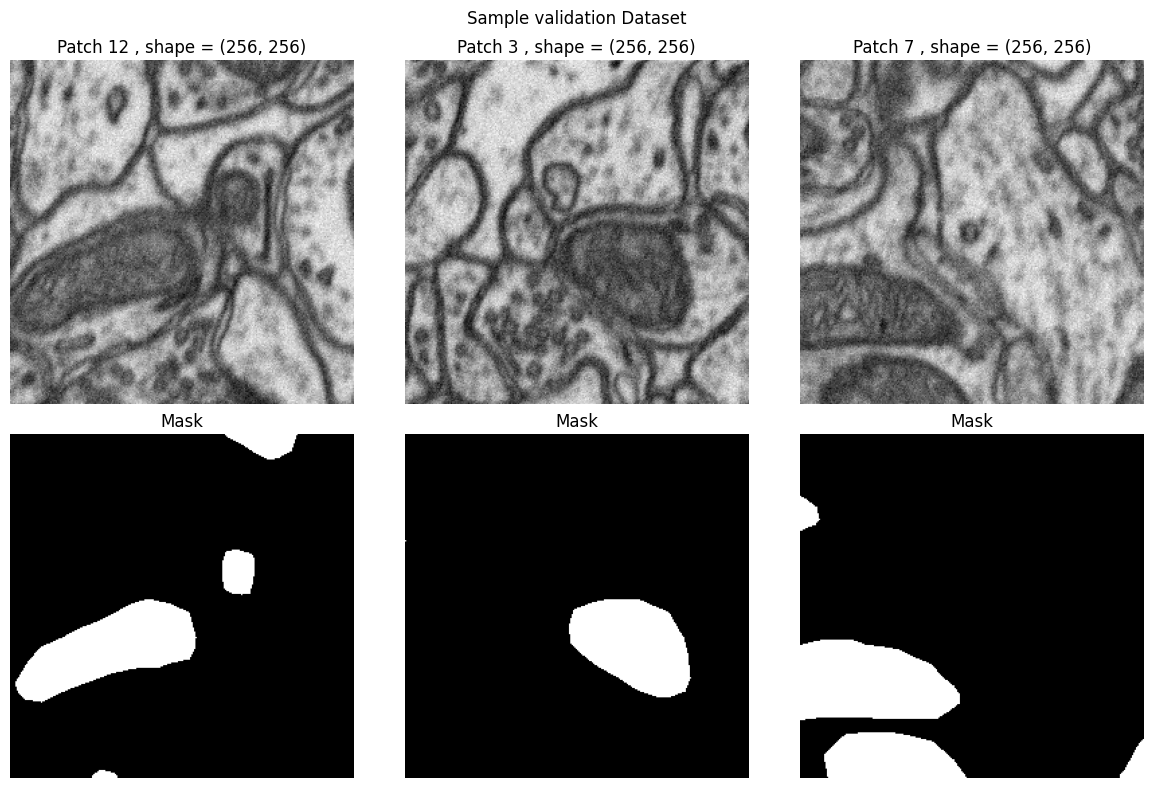

In [ ]:
# Visualize a few kept patches
# val_filtered_imgs, val_filtered_msks
n_show = 3
idxs = random.sample(range(len(val_filtered_imgs)), n_show)

fig, axes = plt.subplots(2, n_show, figsize=(4*n_show, 8))
for i, idx in enumerate(idxs):
    axes[0, i].imshow(val_filtered_imgs[idx], cmap='gray')
    # Corrected line: access .shape or .size from the image patch, not the loop counter 'i'
    axes[0, i].set_title(f"Patch {idx} , shape = {val_filtered_imgs[idx].shape}") # Using .shape for dimensions
    axes[1, i].imshow(val_filtered_msks[idx], cmap='gray')
    axes[1, i].set_title("Mask")
    for a in (axes[0,i], axes[1,i]):
        a.axis('off')
fig.suptitle('Sample validation Dataset') # Changed plt.title to fig.suptitle
plt.tight_layout()

plt.show()

## Now prepare Augmentation

- HorizontalFlip
- VerticalFlip
- RandomRotate90
- ShiftScaleRotate
- ElasticTransform
- GaussNoise
- GaussianBlur
- PoisionNoise
- zoom in
- zoom out (fill with repreatuion)
- random crop
- random brightness



In [ ]:
import albumentations as A
import numpy as np # Ensure numpy is imported
import cv2 # Import OpenCV for border_mode

def augment_data(image, mask):
    """
    Applies a series of albumentations transformations to an image and its corresponding mask,
    returning the original image/mask pair and three additional augmented pairs.
    Geometric transformations are applied to both image and mask.
    Non-geometric transformations are applied only to the image.

    Args:
        image (numpy.ndarray): The input image.
        mask (numpy.ndarray): The input mask.

    Returns:
        list: A list of four tuples, where each tuple contains (transformed_image, transformed_mask).
              The first tuple is the original (image, mask).
    """

    geometric_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.025, scale_limit=0.1, rotate_limit=45, p=0.5, border_mode=cv2.BORDER_REFLECT), # Added border_mode
        A.ElasticTransform(alpha=1, sigma=20, p=0.5), # Removed alpha_affine as it's not a valid argument
        # A.RandomCrop(height=256, width=256, p=0.5), # Included RandomCrop as requested
    ])

    non_geometric_transform = A.Compose([
        A.GaussNoise(p=0.2),
        A.GaussianBlur(blur_limit=(1,2), p=0.2),
        # A.PoissonNoise(p=0.5), # Removed PoissonNoise due to AttributeError
        A.RandomBrightnessContrast(p=0.2)
    ])

    augmented_data_list = [(image, mask)] # Start with the original image and mask

    for _ in range(3): # Generate 3 additional augmented samples
        # Apply geometric transformations to both image and mask
        geometric_augmented = geometric_transform(image=image, mask=mask)
        geo_image = geometric_augmented['image']
        geo_mask = geometric_augmented['mask']

        # Apply non-geometric transformations ONLY to the geometrically augmented image
        # The mask remains unchanged by these transformations
        non_geometric_augmented_image = non_geometric_transform(image=geo_image)['image']

        augmented_data_list.append((non_geometric_augmented_image, geo_mask))

    return augmented_data_list

print("Augmentation function 'augment_data' modified to return original and 3 augmented image-mask pairs with selective transformations.")

Augmentation function 'augment_data' modified to return original and 3 augmented image-mask pairs with selective transformations.


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


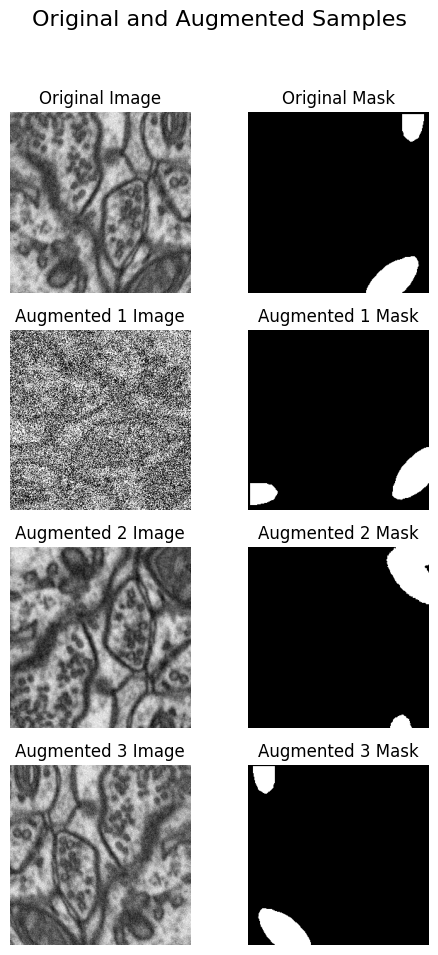

In [ ]:
# Pick a sample image and mask from the filtered training set
# Using the first available patch for demonstration
sample_image = train_filtered_imgs[0]
sample_mask = train_filtered_msks[0]

# Augment the data
augmented_samples = augment_data(sample_image, sample_mask)

# Visualize the original and augmented samples
fig, axes = plt.subplots(4, 2, figsize=(5, 10))

for i, (img, msk) in enumerate(augmented_samples):
    title_prefix = "Original" if i == 0 else f"Augmented {i}"
    axes[i, 0].imshow(img, cmap='gray')
    axes[i, 0].set_title(f"{title_prefix} Image")
    axes[i, 0].axis('off')

    axes[i, 1].imshow(msk, cmap='gray')
    axes[i, 1].set_title(f"{title_prefix} Mask")
    axes[i, 1].axis('off')

fig.suptitle("Original and Augmented Samples", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make space for suptitle
plt.show()

In [ ]:
train_augmented_imgs = []
train_augmented_msks = []

# val_augmented_imgs = []
# val_augmented_msks = []

val_augmented_imgs = val_filtered_imgs
val_augmented_msks = val_filtered_msks

# Augment training data
for img, msk in zip(train_filtered_imgs, train_filtered_msks):
    augmented_pairs = augment_data(img, msk)
    for a_img, a_msk in augmented_pairs:
        train_augmented_imgs.append(a_img)
        train_augmented_msks.append(a_msk)

# # Augment validation data
# for img, msk in zip(val_filtered_imgs, val_filtered_msks):
#     augmented_pairs = augment_data(img, msk)
#     for a_img, a_msk in augmented_pairs:
#         val_augmented_imgs.append(a_img)
#         val_augmented_msks.append(a_msk)

print(f"Original train patches: {len(train_filtered_imgs)}, Augmented train samples: {len(train_augmented_imgs)}")
print(f"Original val patches: {len(val_filtered_imgs)}, Augmented val samples: {len(val_augmented_imgs)}")

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Original train patches: 152, Augmented train samples: 608
Original val patches: 33, Augmented val samples: 33


Displaying 4 augmented training samples...


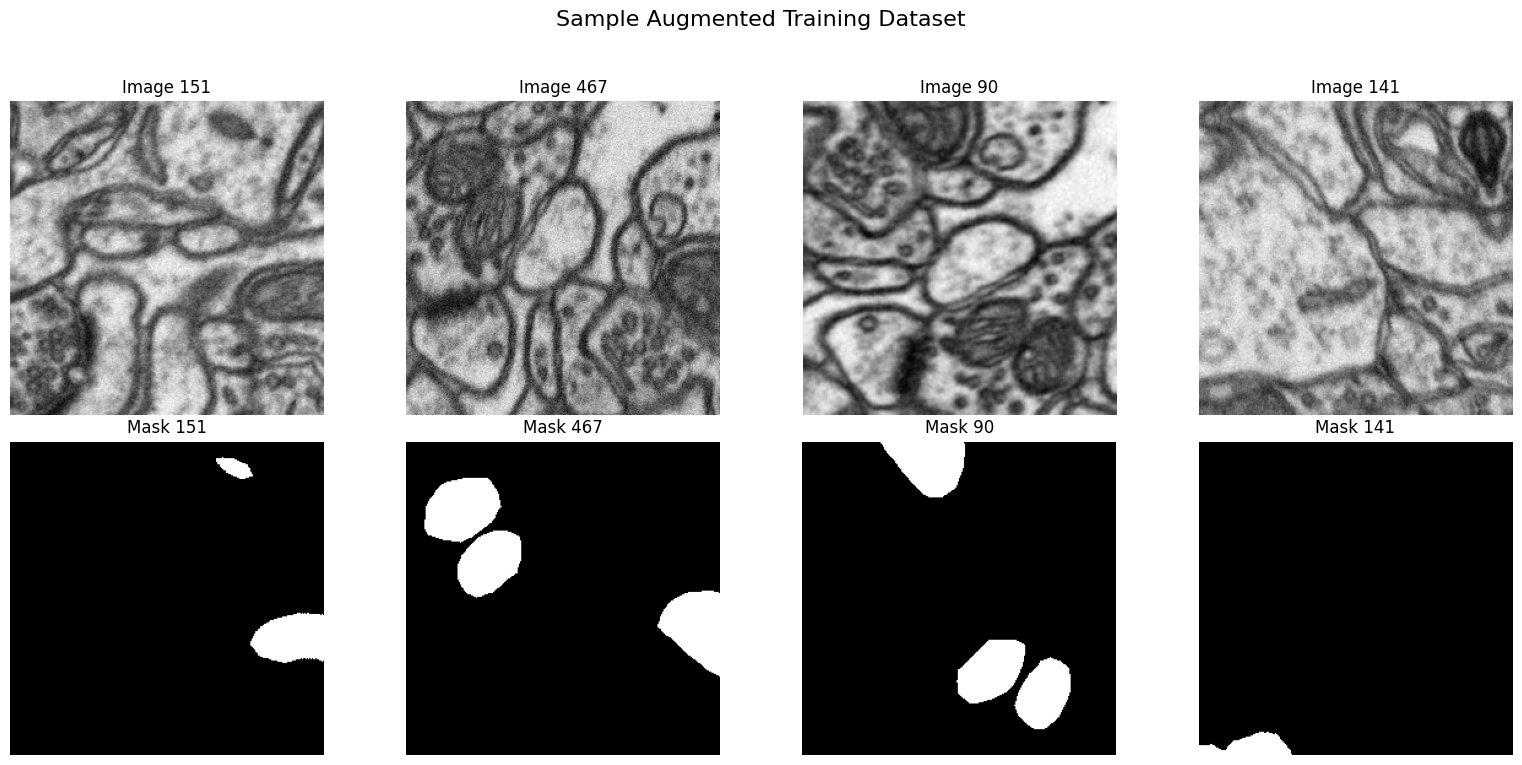

In [ ]:
import random
import matplotlib.pyplot as plt

# Number of augmented samples to display
n_show = 4

print(f"Displaying {n_show} augmented training samples...")
idxs = random.sample(range(len(train_augmented_imgs)), n_show)

# 2 rows: top = images, bottom = masks
fig, axes = plt.subplots(2, n_show, figsize=(4 * n_show, 8))

for col, idx in enumerate(idxs):
    img = train_augmented_imgs[idx]
    msk = train_augmented_msks[idx]

    # Top row: images
    axes[0, col].imshow(img, cmap='gray')
    axes[0, col].set_title(f"Image {idx}")
    axes[0, col].axis('off')

    # Bottom row: masks
    axes[1, col].imshow(msk, cmap='gray')
    axes[1, col].set_title(f"Mask {idx}")
    axes[1, col].axis('off')

fig.suptitle('Sample Augmented Training Dataset', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



Displaying 4 validation samples...


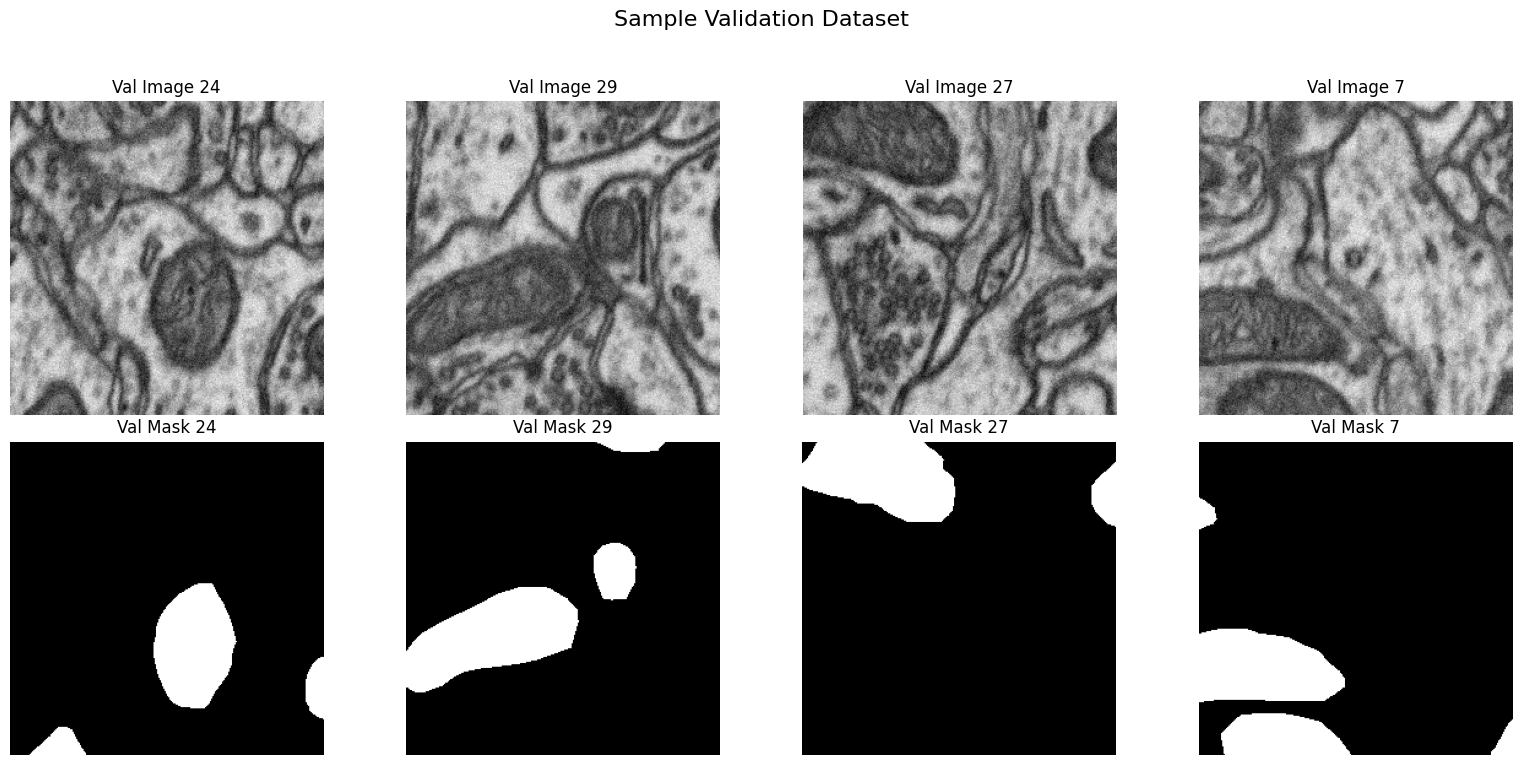

In [ ]:
# Visualize a few validation samples (optional, but good for verification)
print(f"\nDisplaying {n_show} validation samples...")
idxs = random.sample(range(len(val_augmented_imgs)), n_show)

# 2 rows: top = images, bottom = masks
fig, axes = plt.subplots(2, n_show, figsize=(4 * n_show, 8))

for col, idx in enumerate(idxs):
    img = val_augmented_imgs[idx]
    msk = val_augmented_msks[idx]

    # Top row: images
    axes[0, col].imshow(img, cmap='gray')
    axes[0, col].set_title(f"Val Image {idx}")
    axes[0, col].axis('off')

    # Bottom row: masks
    axes[1, col].imshow(msk, cmap='gray')
    axes[1, col].set_title(f"Val Mask {idx}")
    axes[1, col].axis('off')

fig.suptitle('Sample Validation Dataset', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [ ]:
print('---Printing Augmentated Data informations---')
print(f"Original train patches: {len(train_filtered_imgs)}, Augmented train samples: {len(train_augmented_imgs)}")
print(f"Original val patches: {len(val_filtered_imgs)}, Augmented val samples: {len(val_augmented_imgs)}")

---Printing Augmentated Data informations---
Original train patches: 152, Augmented train samples: 608
Original val patches: 33, Augmented val samples: 33


## Normalize the data

In [ ]:
from csbdeep.utils import normalize

def normalize_image_data(images, masks):
    """
    Applies percentile normalization to a list of images and returns the corresponding masks as is.

    Args:
        images (list): A list of image (numpy.ndarray) arrays.
        masks (list): A list of mask (numpy.ndarray) arrays.

    Returns:
        tuple: A tuple containing two lists: normalized images and original masks.
    """
    normalized_images = []
    for img in images:
        # Apply percentile normalization using csbdeep's normalize function
        # 1st and 99.8th percentiles are common choices for robust normalization
        norm_img = normalize(img, 1, 99.8, axis=(0,1))
        normalized_images.append(norm_img)
    return normalized_images, masks

# Apply the normalization function to training and validation augmented data
train_data_norm_aug, train_mask_norm_au = normalize_image_data(train_augmented_imgs, train_augmented_msks)
val_data_norm_aug, val_mask_norm_au = normalize_image_data(val_augmented_imgs, val_augmented_msks)

print("Data normalization applied and new variables created:")
print(f"  train_data_nor_aug: {len(train_data_norm_aug)} images, dtype: {train_data_norm_aug[0].dtype}")
print(f"  train_mask_norm_au: {len(train_mask_norm_au)} masks, dtype: {train_mask_norm_au[0].dtype}")
print(f"  val_data_nor_aug: {len(val_data_norm_aug)} images, dtype: {val_data_norm_aug[0].dtype}")
print(f"  val_mask_norm_au: {len(val_mask_norm_au)} masks, dtype: {val_mask_norm_au[0].dtype}")


Data normalization applied and new variables created:
  train_data_nor_aug: 608 images, dtype: float32
  train_mask_norm_au: 608 masks, dtype: uint8
  val_data_nor_aug: 33 images, dtype: float32
  val_mask_norm_au: 33 masks, dtype: uint8


--- Data Differences Before and After Normalization (Sample Index: 0) ---

Original Augmented Image:
  Data Type: uint8
  Min Value: 57
  Max Value: 212
  Mean Value: 132.2282

Original Augmented Mask:
  Data Type: uint8
  Min Value: 0
  Max Value: 255
  Mean Value: 13.6263
  (Note: Masks are typically binary and not normalized like images)

Normalized Image:
  Data Type: float32
  Min Value: -0.2034
  Max Value: 1.1102
  Mean Value: 0.4341

Normalized Mask (unchanged from original augmented mask):
  Data Type: uint8
  Min Value: 0
  Max Value: 255
  Mean Value: 13.6263


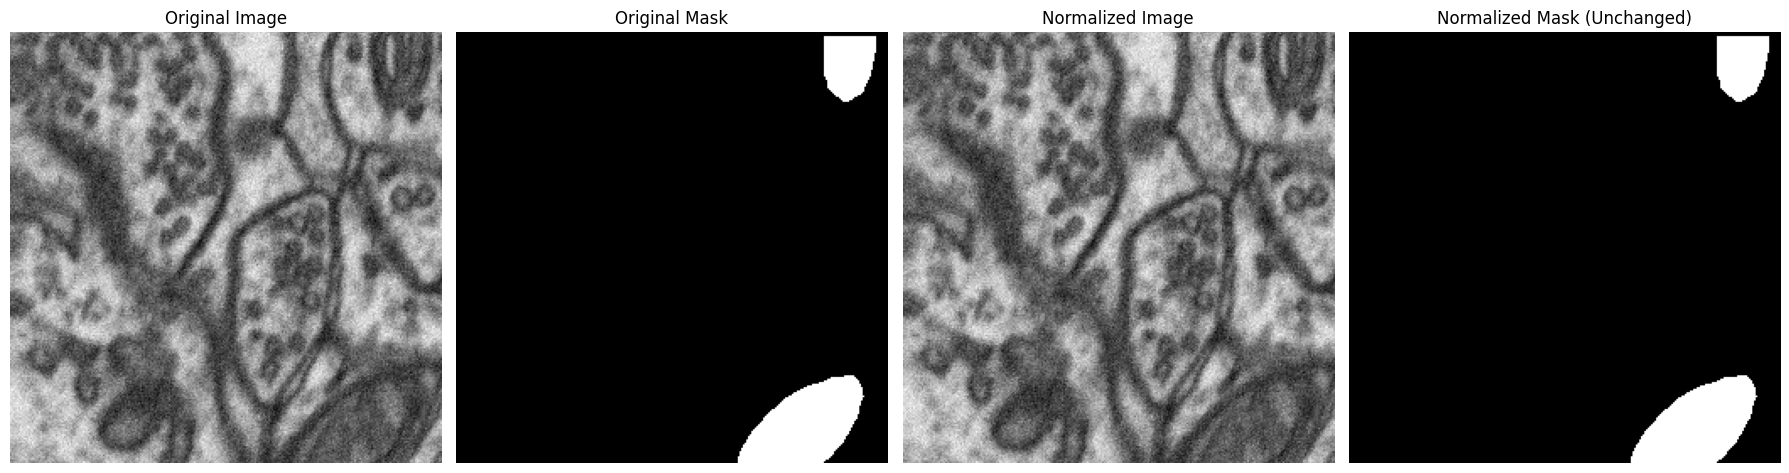

In [ ]:
# Select a sample image before and after normalization
sample_idx = 0 # Using the first image for demonstration

original_augmented_image = train_augmented_imgs[sample_idx]
original_augmented_mask = train_augmented_msks[sample_idx]
normalized_image = train_data_norm_aug[sample_idx]
normalized_mask = train_mask_norm_au[sample_idx] # Mask is not normalized, just passed through

print(f"--- Data Differences Before and After Normalization (Sample Index: {sample_idx}) ---")

print("\nOriginal Augmented Image:")
print(f"  Data Type: {original_augmented_image.dtype}")
print(f"  Min Value: {original_augmented_image.min()}")
print(f"  Max Value: {original_augmented_image.max()}")
print(f"  Mean Value: {original_augmented_image.mean():.4f}")

print("\nOriginal Augmented Mask:")
print(f"  Data Type: {original_augmented_mask.dtype}")
print(f"  Min Value: {original_augmented_mask.min()}")
print(f"  Max Value: {original_augmented_mask.max()}")
print(f"  Mean Value: {original_augmented_mask.mean():.4f}")
print("  (Note: Masks are typically binary and not normalized like images)")

print("\nNormalized Image:")
print(f"  Data Type: {normalized_image.dtype}")
print(f"  Min Value: {normalized_image.min():.4f}")
print(f"  Max Value: {normalized_image.max():.4f}")
print(f"  Mean Value: {normalized_image.mean():.4f}")

print("\nNormalized Mask (unchanged from original augmented mask):")
print(f"  Data Type: {normalized_mask.dtype}")
print(f"  Min Value: {normalized_mask.min()}")
print(f"  Max Value: {normalized_mask.max()}")
print(f"  Mean Value: {normalized_mask.mean():.4f}")

# Visualize them side-by-side to see visual impact
fig, axes = plt.subplots(1, 4, figsize=(18, 5)) # Changed to 4 columns

axes[0].imshow(original_augmented_image, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(original_augmented_mask, cmap='gray')
axes[1].set_title('Original Mask')
axes[1].axis('off')

axes[2].imshow(normalized_image, cmap='gray')
axes[2].set_title('Normalized Image')
axes[2].axis('off')

axes[3].imshow(normalized_mask, cmap='gray')
axes[3].set_title('Normalized Mask (Unchanged)')
axes[3].axis('off')

plt.tight_layout()
plt.show()

# save the prepared data

In [ ]:
import numpy as np
import os

# Define the base directory where the original data was loaded from
# This assumes '/content/drive/MyDrive/Electron_Microscope_Practice_Projects/Mitochondria_segmentation/'
# is the correct path where the original .tif files reside.
base_dir = "/content/drive/MyDrive/Electron_Microscope_Practice_Projects/Mitochondria_segmentation/"

# Convert lists of images/masks to single NumPy arrays for saving
# Stack them to create a 4D array if they are 2D patches
# For images, stack them directly
train_images_to_save = np.array(train_data_norm_aug)
train_masks_to_save  = np.array(train_mask_norm_au)

val_images_to_save = np.array(val_data_norm_aug)
val_masks_to_save  = np.array(val_mask_norm_au)

# Define filenames for saving
train_output_filename = os.path.join(base_dir, 'train_data_processed.npz')
val_output_filename   = os.path.join(base_dir, 'val_data_processed.npz')

# Save the training data
np.savez_compressed(train_output_filename,
                    images=train_images_to_save,
                    masks=train_masks_to_save)
print(f"Training data saved to: {train_output_filename}")
print(f"  Images shape: {train_images_to_save.shape}, Masks shape: {train_masks_to_save.shape}")

# Save the validation data
np.savez_compressed(val_output_filename,
                    images=val_images_to_save,
                    masks=val_masks_to_save)
print(f"Validation data saved to: {val_output_filename}")
print(f"  Images shape: {val_images_to_save.shape}, Masks shape: {val_masks_to_save.shape}")

print("Data saved successfully for later use.")

Training data saved to: /content/drive/MyDrive/Electron_Microscope_Practice_Projects/Mitochondria_segmentation/train_data_processed.npz
  Images shape: (608, 256, 256), Masks shape: (608, 256, 256)
Validation data saved to: /content/drive/MyDrive/Electron_Microscope_Practice_Projects/Mitochondria_segmentation/val_data_processed.npz
  Images shape: (33, 256, 256), Masks shape: (33, 256, 256)
Data saved successfully for later use.


## load the data set

In [ ]:
import numpy as np
import os

# Define the path to one of the saved NPZ files
# Assuming 'train_data_processed.npz' as an example
base_dir = "/content/drive/MyDrive/Electron_Microscope_Practice_Projects/Mitochondria_segmentation/"
npz_filepath = os.path.join(base_dir, 'train_data_processed.npz')

print(f"--- Metadata for {os.path.basename(npz_filepath)} ---")

try:
    # Load the NPZ file
    with np.load(npz_filepath) as data:
        print("Available arrays (keys):", list(data.keys()))

        # Optionally, print shape and dtype for each array
        for key in data.keys():
            print(f"  '{key}' shape: {data[key].shape}")
            print(f"  '{key}' dtype: {data[key].dtype}")
except FileNotFoundError:
    print(f"Error: The file {npz_filepath} was not found. Please ensure it exists.")
except Exception as e:
    print(f"An error occurred while loading the NPZ file: {e}")

--- Metadata for train_data_processed.npz ---
Available arrays (keys): ['images', 'masks']
  'images' shape: (608, 256, 256)
  'images' dtype: float32
  'masks' shape: (608, 256, 256)
  'masks' dtype: uint8
